In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/PTA-PX.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['PTA-0.66*PX盘面价差（期货指数）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,PTA-0.66*PX盘面价差（期货指数）,结算价:PTA指数,结算价:对二甲苯指数
2025-12-02,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN
2025-12-08,NaN,NaN,NaN


In [5]:
sheet1 = pd.ExcelFile('eta/结算价-PTA指数_合并数据.xlsx').parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1 = sheet1.drop(columns=['结算价:PTA指数'])
sheet1 = sheet1.dropna()
sheet1.head()

,Date,结算价:PTA指数_预测
20,2025-11-08,4663.000000
19,2025-11-10,4643.400687
18,2025-11-11,4665.948830
17,2025-11-12,4669.932963
16,2025-11-13,4680.986384


In [6]:
sheet2 = pd.ExcelFile('eta/结算价_对二甲苯指数_合并数据.xlsx').parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2 = sheet2.drop(columns=['结算价:对二甲苯指数'])
sheet2 = sheet2.dropna()
sheet2.head()

,Date,结算价:对二甲苯指数_预测
20,2025-11-10,6750.039350
19,2025-11-11,6793.386875
18,2025-11-12,6790.691406
17,2025-11-13,6819.892088
16,2025-11-14,6770.108000


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '结算价:PTA指数_预测']],
    on='Date',
    how='left'
)
sheet_daily['结算价:PTA指数'] = sheet_daily['结算价:PTA指数'].fillna(sheet_daily['结算价:PTA指数_预测'])
sheet_daily = sheet_daily.drop(columns=['结算价:PTA指数_预测'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '结算价:对二甲苯指数_预测']],
    on='Date',
    how='left'
)
sheet_daily['结算价:对二甲苯指数'] = sheet_daily['结算价:对二甲苯指数'].fillna(sheet_daily['结算价:对二甲苯指数_预测'])
sheet_daily = sheet_daily.drop(columns=['结算价:对二甲苯指数_预测'])


sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,PTA-0.66*PX盘面价差（期货指数）,结算价:PTA指数,结算价:对二甲苯指数
4601,2025-11-25,NaN,4828.234179,6936.124319
4602,2025-11-26,NaN,4735.524023,6792.197394
4603,2025-11-27,NaN,4677.247072,6742.406000
4604,2025-11-28,NaN,4717.165078,6764.358200
4605,2025-12-01,NaN,4620.178189,6708.555031
4606,2025-12-02,NaN,4705.061773,6782.229138
4607,2025-12-03,NaN,4750.775572,6811.122337
4608,2025-12-04,NaN,4727.108959,6816.725613
4609,2025-12-05,NaN,4658.919834,6725.702450
4610,2025-12-08,NaN,NaN,NaN


In [8]:
#  添加新列 山东汽油裂解差_预测
sheet_daily['PTA-PX_预测'] = sheet_daily['结算价:PTA指数'] - 0.66*sheet_daily['结算价:对二甲苯指数']
sheet_daily.tail()

,Date,PTA-0.66*PX盘面价差（期货指数）,结算价:PTA指数,结算价:对二甲苯指数,PTA-PX_预测
4606,2025-12-02,NaN,4705.061773,6782.229138,228.790542
4607,2025-12-03,NaN,4750.775572,6811.122337,255.434830
4608,2025-12-04,NaN,4727.108959,6816.725613,228.070054
4609,2025-12-05,NaN,4658.919834,6725.702450,219.956217
4610,2025-12-08,NaN,NaN,NaN,NaN


In [9]:
last_day = sheet_daily['Date'][sheet_daily['PTA-0.66*PX盘面价差（期货指数）'].last_valid_index()]

---

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', 'PTA-0.66*PX盘面价差（期货指数）']]
historical.columns = ['Date', 'PTA-0.66*PX盘面价差（期货指数）']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', 'PTA-PX_预测']]
forecast.columns = ['Date', 'PTA-PX_预测']



# 获取最后一个有主焦煤价格/临汾值的行
last_price_row = historical.iloc[-1]
last_price_date = pd.to_datetime(last_price_row['Date'])
last_price = last_price_row['PTA-0.66*PX盘面价差（期货指数）']
# 创建新行,日期为最后一个有值日期的后一天
new_row = pd.DataFrame({
    'Date': [last_price_date + pd.Timedelta(days=1)],
    'PTA-0.66*PX盘面价差（期货指数）': [np.nan],
    'PTA-PX_预测': [last_price]
})
# 将新行添加到forecast中
forecast = pd.concat([new_row, forecast])


# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
# 删除两列都为空的行
merged_df_daily = merged_df_daily.dropna(subset=['PTA-0.66*PX盘面价差（期货指数）', 'PTA-PX_预测'], how='all')
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/PTA-PX_合并数据.xlsx', index=False,float_format='%.6f')   
merged_df_daily.head() 

,Date,PTA-0.66*PX盘面价差（期货指数）,PTA-PX_预测
611,2025/12/05,NaN,219.956217
610,2025/12/04,NaN,228.070054
609,2025/12/03,NaN,255.434830
608,2025/12/02,NaN,228.790542
607,2025/12/01,NaN,192.531869


In [11]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', 'PTA-0.66*PX盘面价差（期货指数）']]
historical_monthly.columns = ['Date', 'PTA-0.66*PX盘面价差（期货指数）']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', 'PTA-PX_预测']]
forecast_monthly.columns = ['Date', 'PTA-PX_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.dropna(subset=['PTA-0.66*PX盘面价差（期货指数）', 'PTA-PX_预测'], how='all')
merged_df_monthly.to_excel('eta/PTA-PX_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,PTA-0.66*PX盘面价差（期货指数）,PTA-PX_预测
30,2025/12/31,NaN,224.956702
29,2025/11/30,213.988000,213.795722
28,2025/10/31,245.830588,245.830588
27,2025/09/30,249.964545,249.964545
26,2025/08/31,265.447619,265.447619


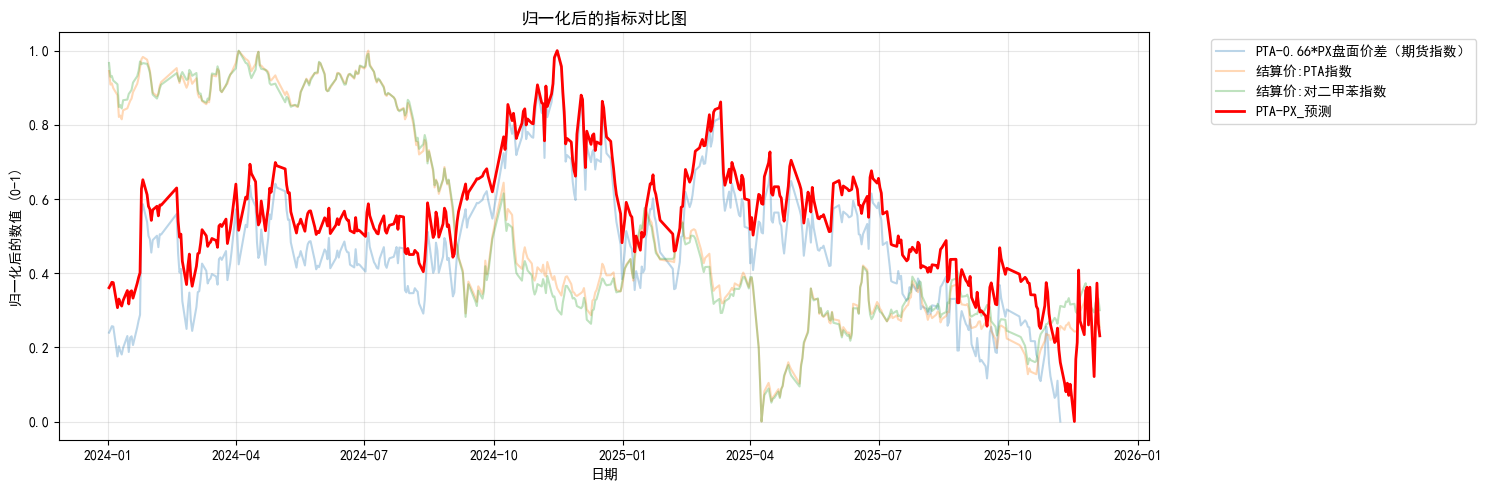

In [12]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = sheet_daily.copy()
normalized_df1 = sheet_daily.copy()
# 筛选2024年及以后的数据
normalized_df = normalized_df[normalized_df['Date'] >= '2024-01-01'].copy()
normalized_df1 = normalized_df1[normalized_df1['Date'] >= '2024-01-01'].copy()
# 对每一列进行归一化处理(除了Date列)
scaler = MinMaxScaler()
columns_to_normalize = [col for col in sheet_daily.columns if col != 'Date']
normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df1[columns_to_normalize])


# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == 'PTA-PX_预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



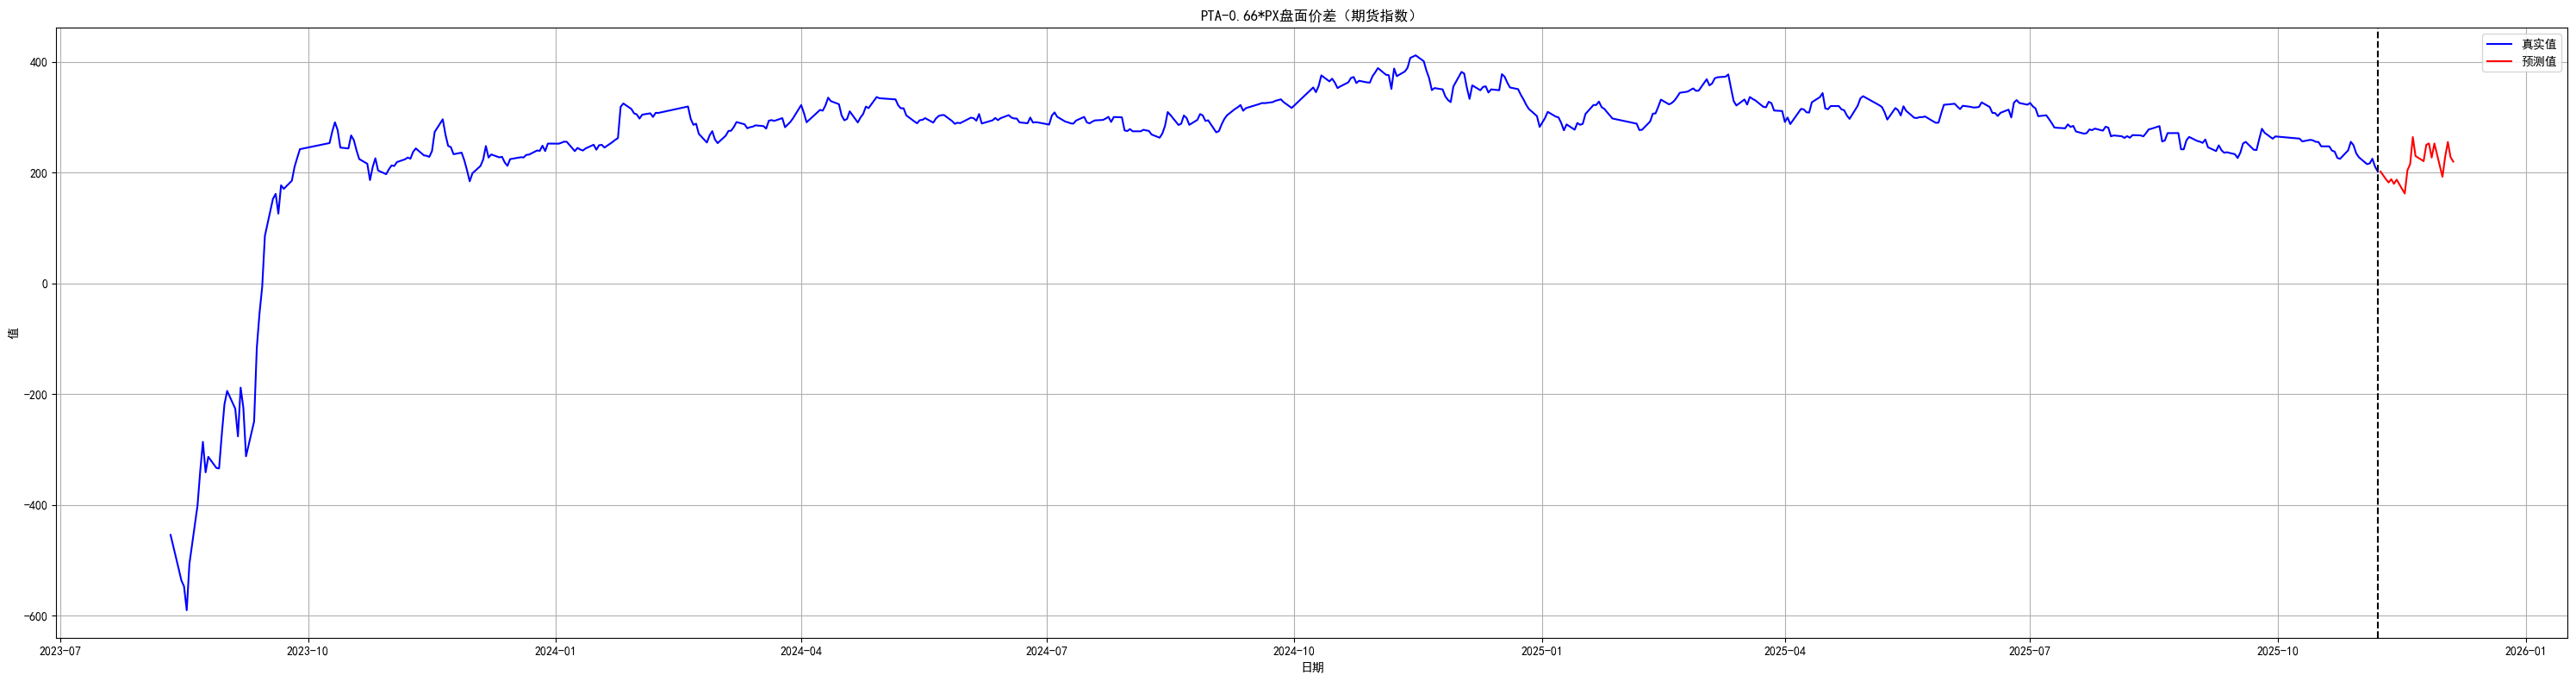

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['PTA-0.66*PX盘面价差（期货指数）'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['PTA-PX_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('PTA-0.66*PX盘面价差（期货指数）')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "PTA-PX"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "PTA-PX"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [16]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'LME铜价',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'LME铜价\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'